# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap      

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [5]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(valid_data, batch_size = 16, shuffle = True)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.fc = nn.Linear(64, 10)
        self.conv_1_16 = nn.Conv2d(1, 16, 3, padding = 1)
        self.first_conv_16_16 = nn.Conv2d(16, 16, 3, padding = 1)
        self.second_conv_16_16 = nn.Conv2d(16, 16, 3, padding = 1)
        self.conv_16_64 = nn.Conv2d(16, 64, 3, padding = 1)
        self.first_conv_64_64 = nn.Conv2d(64, 64, 3, padding = 1)
        self.second_conv_64_64 = nn.Conv2d(64, 64, 3, padding = 1)
        

    def forward(self, x):
        return F.softmax(self.fc(torch.flatten(F.adaptive_avg_pool2d(torch.add(F.relu(self.conv_16_64(F.max_pool2d(torch.add(F.max_pool2d(F.relu(self.conv_1_16(x)), 2),
                                                                               F.relu(self.second_conv_16_16(F.relu(self.first_conv_16_16(F.max_pool2d(F.relu(self.conv_1_16(x)), 2)))))), 2))),
                                                                               F.relu(self.second_conv_64_64(F.relu(self.first_conv_64_64(F.relu(self.conv_16_64(F.max_pool2d(torch.add(F.max_pool2d(F.relu(self.conv_1_16(x)), 2), 
                                                                               F.relu(self.second_conv_16_16(F.relu(self.first_conv_16_16(F.max_pool2d(F.relu(self.conv_1_16(x)), 2)))))), 2)))))))), 1), 1)), dim = 1)

# Train Model (30 Points)

In [7]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
accuracy = []
losses = []
for epoch in range(num_epochs):
    for images, labels in tqdm(train_loader):  
        optimizer.zero_grad()
        predict = model(images.to(device))
        loss = criterion(predict, labels.to(device))
        loss.backward()
        optimizer.step()
    print(f"Loss ({epoch}/{num_epochs}) : {loss.item()}")
    losses.append(loss.item())
    all_predictions = 0 
    correct_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            preds = model(images.to(device))
            pred_labels = torch.max(preds, 1)[1]
            all_predictions += labels.to(device).size(0)
            for i in range(len(pred_labels)):
              if pred_labels[i] == labels.to(device)[i]:
                correct_predictions += 1
        epoch_accuracy = correct_predictions/all_predictions
        print(f'accuracy: {epoch_accuracy}')
        accuracy.append(epoch_accuracy)

100%|██████████| 3125/3125 [00:35<00:00, 87.82it/s] 


Loss (0/20) : 1.6466429233551025
accuracy: 0.7116


100%|██████████| 3125/3125 [00:27<00:00, 113.40it/s]


Loss (1/20) : 1.7785115242004395
accuracy: 0.7967


100%|██████████| 3125/3125 [00:27<00:00, 113.03it/s]


Loss (2/20) : 1.5455554723739624
accuracy: 0.8417


100%|██████████| 3125/3125 [00:27<00:00, 112.33it/s]


Loss (3/20) : 1.6666104793548584
accuracy: 0.8532


100%|██████████| 3125/3125 [00:27<00:00, 111.81it/s]


Loss (4/20) : 1.6440730094909668
accuracy: 0.8622


100%|██████████| 3125/3125 [00:27<00:00, 115.46it/s]


Loss (5/20) : 1.5333037376403809
accuracy: 0.8615


100%|██████████| 3125/3125 [00:27<00:00, 114.45it/s]


Loss (6/20) : 1.584505558013916
accuracy: 0.8651


100%|██████████| 3125/3125 [00:26<00:00, 115.91it/s]


Loss (7/20) : 1.5449085235595703
accuracy: 0.874


100%|██████████| 3125/3125 [00:27<00:00, 115.43it/s]


Loss (8/20) : 1.647065281867981
accuracy: 0.8682


100%|██████████| 3125/3125 [00:27<00:00, 114.92it/s]


Loss (9/20) : 1.70406174659729
accuracy: 0.8681


100%|██████████| 3125/3125 [00:27<00:00, 115.33it/s]


Loss (10/20) : 1.5802650451660156
accuracy: 0.8656


100%|██████████| 3125/3125 [00:27<00:00, 115.07it/s]


Loss (11/20) : 1.5929348468780518
accuracy: 0.8768


100%|██████████| 3125/3125 [00:27<00:00, 115.18it/s]


Loss (12/20) : 1.583274483680725
accuracy: 0.8795


100%|██████████| 3125/3125 [00:26<00:00, 115.85it/s]


Loss (13/20) : 1.4640865325927734
accuracy: 0.8755


100%|██████████| 3125/3125 [00:27<00:00, 115.02it/s]


Loss (14/20) : 1.523300290107727
accuracy: 0.8788


100%|██████████| 3125/3125 [00:27<00:00, 114.22it/s]


Loss (15/20) : 1.64457106590271
accuracy: 0.8811


100%|██████████| 3125/3125 [00:27<00:00, 114.51it/s]


Loss (16/20) : 1.537847876548767
accuracy: 0.8841


100%|██████████| 3125/3125 [00:27<00:00, 113.02it/s]


Loss (17/20) : 1.5229346752166748
accuracy: 0.8856


100%|██████████| 3125/3125 [00:27<00:00, 113.37it/s]


Loss (18/20) : 1.5824397802352905
accuracy: 0.8858


100%|██████████| 3125/3125 [00:28<00:00, 111.14it/s]


Loss (19/20) : 1.5318052768707275
accuracy: 0.8832


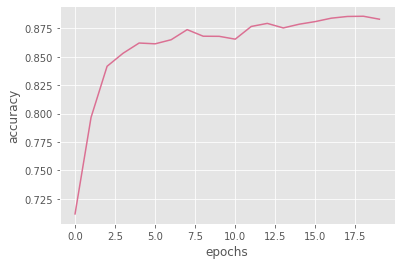

In [9]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.plot(range(20), accuracy, color="palevioletred")
plt.show()


# Test Model (20 Points)

10000


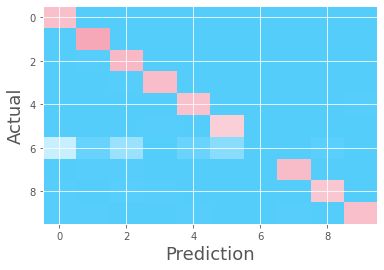

In [10]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
confusion = np.zeros((10, 10))
with torch.no_grad():
    for images, labels in test_loader:
            labels = labels.detach().cpu().numpy()
            preds = model(images.to(device))
            pred_labels = (torch.max(preds, 1)[1]).detach().cpu().numpy()
            for i in range(len(labels)):
              confusion[labels[i]][pred_labels[i]] += 1

tcolors = {'red':   [[0.0,  0.333, 0.333],
                   [0.5,  1.0, 1.0],
                   [1.0,  0.969, 0.969]],
         'green': [[0.0,  0.804, 0.804],
                   [0.5, 1.0, 1.0],
                   [1.0,  0.659, 0.659]],
         'blue':  [[0.0,  0.988, 0.988],
                   [0.5,  1.0, 1.0],
                   [1.0,  0.722, 0.722]]} 

tmap = LinearSegmentedColormap('tcolors', tcolors)      
plt.xlabel('Prediction', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.imshow(confusion, aspect='auto', cmap=tmap)

plt.show()